# Data Cleaning Lecture Notebook

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Load the tips dataset from Seaborn
df = sns.load_dataset('tips')

In [30]:
df.shape

(244, 7)

# 1. Handling Missing Data

In [31]:
# Create a copy of the dataset and introduce missing values
df_missing = df.copy()
df_missing.loc[np.random.choice(df.index, 10), 'total_bill'] = np.nan
df_missing.loc[np.random.choice(df.index, 10), 'sex'] = np.nan

df_missing.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,NaN,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [32]:
# Identify missing values
df_missing.isnull().sum()

total_bill    10
tip            0
sex           10
smoker         0
day            0
time           0
size           0
dtype: int64

In [33]:
# Deletion: Remove records with missing values
df_deleted = df_missing.dropna()
df_deleted.shape

(225, 7)

In [34]:
# Simple Imputation: Fill missing values with mean for numeric columns and mode for categorical
# columns
df_imputed = df_missing.copy()
df_imputed['total_bill'] = df_imputed['total_bill'].fillna(df_imputed['total_bill'].mean())
df_imputed['sex'] = df_imputed['sex'].fillna(df_imputed['sex'].mode()[0])

In [35]:
df_imputed.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [57]:
# Advanced Imputation: KNN Imputation
from sklearn.impute import KNNImputer

# Create a copy of the dataset for KNN imputation
df_imputed_knn = df_missing.copy()

# Initialize and fit the KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_imputed_knn[['total_bill', 'tip', 'size']] = imputer.fit_transform(
    df_imputed_knn[['total_bill', 'tip', 'size']]
)

# 2. Dealing with Duplicates

In [36]:
# Create a copy of the dataset and introduce duplicate records
df_duplicates = pd.concat([df, df.sample(5)], ignore_index=True)

In [37]:
df_duplicates.shape

(249, 7)

In [38]:
# Identify duplicate records
df_duplicates.duplicated().sum()

6

In [60]:
# Show all duplicated rows
df_duplicates[df_duplicates.duplicated(keep='last')]

,total_bill,tip,sex,smoker,day,time,size
46,22.23,5.00,Male,No,Sun,Dinner,2
92,5.75,1.00,Female,Yes,Fri,Dinner,2
123,15.95,2.00,Male,No,Thur,Lunch,2
158,13.39,2.61,Female,No,Sun,Dinner,2
198,13.00,2.00,Female,Yes,Thur,Lunch,2
234,15.53,3.00,Male,Yes,Sat,Dinner,2


In [39]:
# Remove duplicate records
df_deduplicated = df_duplicates.drop_duplicates()

df_deduplicated.shape

(243, 7)

# 3. Data Formatting and Standardization

In [40]:
# Standardize text case for 'sex' and 'smoker' columns
df['sex'] = df['sex'].str.upper()
df['smoker'] = df['smoker'].str.title()

df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,FEMALE,No,Sun,Dinner,2
1,10.34,1.66,MALE,No,Sun,Dinner,3
2,21.01,3.50,MALE,No,Sun,Dinner,3
3,23.68,3.31,MALE,No,Sun,Dinner,2
4,24.59,3.61,FEMALE,No,Sun,Dinner,4


# 4. Handling Outliers

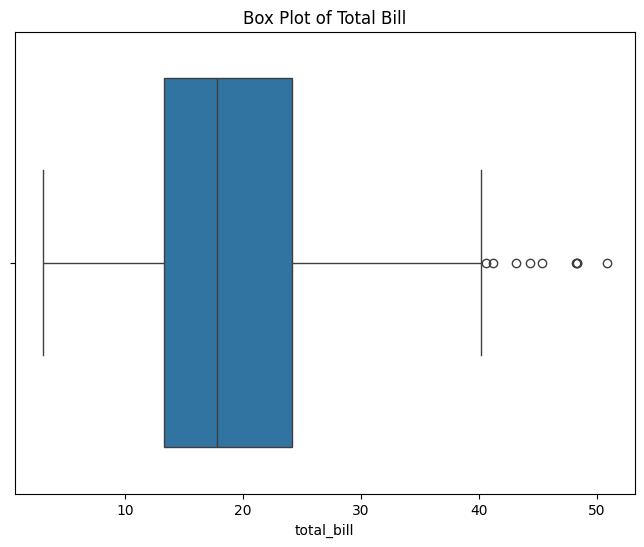

In [41]:
# Identify outliers using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['total_bill'])
plt.title("Box Plot of Total Bill")
plt.show()

In [68]:
# Identify outliers using z-score
from scipy import stats

z_scores = np.abs(stats.zscore(df['total_bill']))
threshold = 2.5
outliers_zscore = np.where(z_scores > threshold)

outliers_zscore

(array([ 59, 102, 156, 170, 182, 197, 212]),)

In [70]:
# Identify outliers using Interquartile Range (IQR)
Q1 = df['total_bill'].quantile(0.25)
Q3 = df['total_bill'].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = df[(df['total_bill'] < (Q1 - 1.5 * IQR)) | (df['total_bill'] > (Q3 + 1.5 * IQR))]
len(outliers_iqr)

9

In [72]:
# Removal: Remove outliers
df_removed = df[~((df['total_bill'] < (Q1 - 1.5 * IQR)) | (df['total_bill'] > (Q3 + 1.5 * IQR)))]
df_removed.shape

(235, 9)

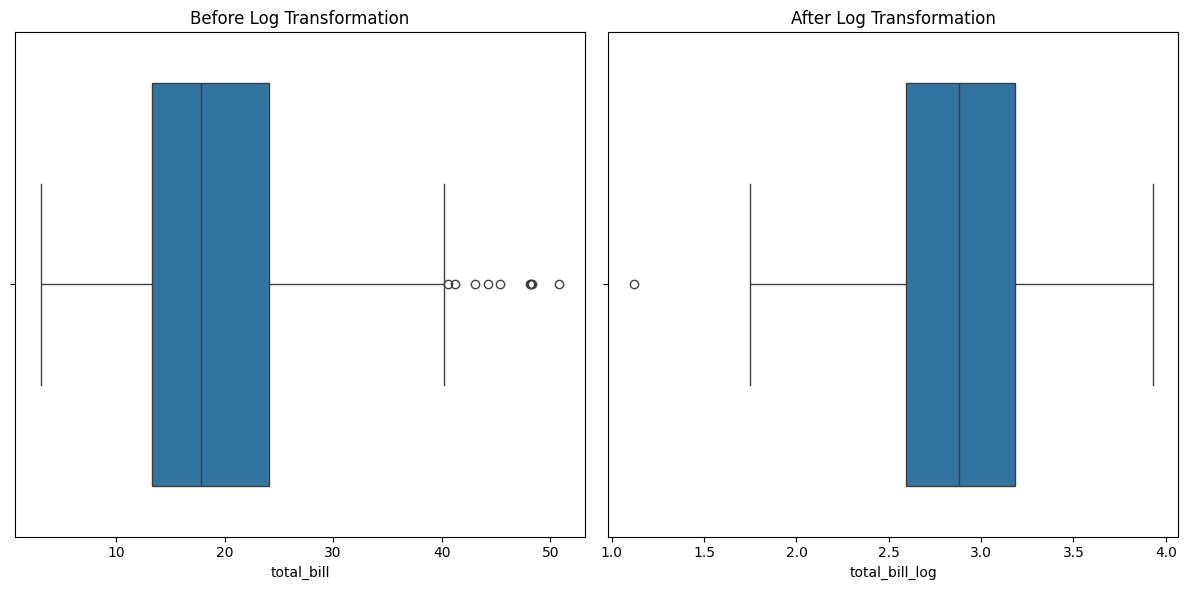

In [73]:
# Transformation: Apply log transformation to reduce the impact of outliers
df['total_bill_log'] = np.log(df['total_bill'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['total_bill'])
plt.title("Before Log Transformation")
plt.subplot(1, 2, 2)
sns.boxplot(x=df['total_bill_log'])
plt.title("After Log Transformation")
plt.tight_layout()
plt.show()

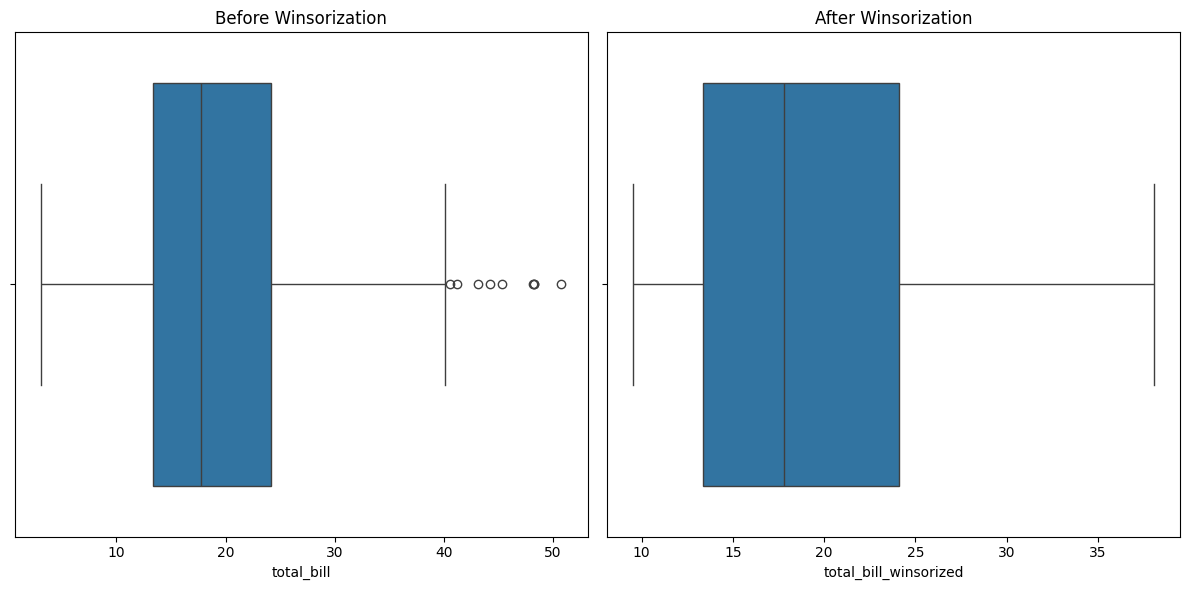

In [74]:
# Winsorization: Replace outliers with nearest non-outlier values
df['total_bill_winsorized'] = stats.mstats.winsorize(df['total_bill'], limits=[0.05, 0.05])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['total_bill'])
plt.title("Before Winsorization")
plt.subplot(1, 2, 2)
sns.boxplot(x=df['total_bill_winsorized'])
plt.title("After Winsorization")
plt.tight_layout()
plt.show()

# 5. Data Validation

In [75]:
# Data type validation
df.dtypes

total_bill                float64
tip                       float64
sex                        object
smoker                     object
day                      category
time                     category
size                        int64
total_bill_winsorized     float64
total_bill_log            float64
dtype: object

In [76]:
# Range validation for 'tip' column
df[(df['tip'] < 0) | (df['tip'] > df['total_bill'])].shape

(0, 9)

In [77]:
# Replace invalid tip values with NaN
df.loc[(df['tip'] < 0) | (df['tip'] > df['total_bill']), 'tip'] = np.nan

In [78]:
df.isnull().sum()

total_bill               0
tip                      0
sex                      0
smoker                   0
day                      0
time                     0
size                     0
total_bill_winsorized    0
total_bill_log           0
dtype: int64